In [1]:
import tkinter as tk
from tkinter import filedialog
import os
import re
import gc
import numpy as np
import tifffile
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
from scipy.signal import find_peaks, peak_prominences
from scipy.signal import peak_widths
import matplotlib.pyplot as plt

In [2]:
# curates mask of pixels from which to extract signal
# pixels are included if correlation coeff is greater than 0.5;
# this works because the noise is random / gaussian and therefore correlation with itself trends to 0
# this is intended only to be a more robust way than manually drawing areas
def get_pixel_mask(first_file_path):
    image_tiff = tifffile.imread(first_file_path)
    size_z, size_y, size_x = image_tiff.shape
    if size_z > 800:
        image_tiff = image_tiff[:800, :, :]

    gui_log_entry(f"Calculating local pixel areas...\n")

    image_smoothed = gaussian_filter(image_tiff, sigma=(3,1,1), mode='reflect')
    image_locals = uniform_filter(image_smoothed, size=(1,10,10), mode='reflect')

    gui_log_entry(f"Generating pixel mask...\n")
    global mask_pixels
    global number_of_pixels
    mask_pixels = np.zeros((size_y, size_x), dtype=float)
    number_of_pixels = 0

    for y in range(size_y):
        for x in range(size_x):
            signal_smoothed = image_smoothed[:, y, x]
            signal_locals = image_locals[:, y, x]
            if np.std(signal_smoothed) == 0 or np.std(signal_locals) == 0:
                correlation_coef = 0
            else:
                correlation_coef = np.corrcoef(signal_smoothed, signal_locals)[0, 1]
            if correlation_coef > 0.5:
                mask_pixels[y, x] = 1
                number_of_pixels += 1

    gui_log_entry(f"Printing mask to Jupyter output...\n")
    gui_log_entry(f"Included pixels: {number_of_pixels}\n")
    plt.imshow(mask_pixels, cmap='viridis')
    plt.title('Included pixels')
    plt.show()
    print("Included pixels: ", number_of_pixels)
    gui_log_entry(f"You may now attempt to extract signal.\n")

    del image_tiff
    del image_smoothed
    del image_locals
    gc.collect()

In [3]:
# x and y dimensions of first tiff
def get_shape_first(file_path):
    image_tiff = tifffile.imread(file_path)
    shape_image = image_tiff.shape
    return shape_image

In [4]:
# gets signal from masked pixels / included pixels
# excludes pixels with a value greater than 500 - most image is 90-110; but top left the pco camera paints numbers with high signal value
def get_signal(file_path, shape_first):
    
    image_tiff = tifffile.imread(file_path)
    shape_image = image_tiff.shape
    if shape_image == shape_first:
        image_masked = image_tiff * mask_pixels
        image_masked = np.ma.masked_values(image_masked, 0)
        image_masked = np.ma.masked_greater(image_masked, 500)
        
        signal = np.ma.mean(image_masked, axis=(1, 2))
        
        del image_tiff
        del image_masked
        gc.collect()
        return signal
    else:
        gui_log_entry(f"Error: image '{file_path}' is not the same shape as {selected_file_paths[0]}.\n")
        del image_tiff
        gc.collect()
        return signal

In [5]:
# crops by first and last peaks - avoids finding a false 'half peak' at beginning and end
def crop_signal(concatenated_signal):

    smoothed_signal = gaussian_filter(concatenated_signal, sigma=11, mode='reflect')

    inverted_signal = -smoothed_signal

    trough_indices = find_peaks(inverted_signal)
    trough_indices = trough_indices[0] 

    cropped_signal = concatenated_signal[trough_indices[0]+1:trough_indices[-1]]

    return cropped_signal

In [6]:
# over/hyper smoothes the signal, uses find peaks, and the finds a corresponding amplitude in the original signal for the peak
# (the over smoothed signal will have reduced amplitudes)
def get_global_peaks(global_data, prominence_val, height_val, threshold_val, distance_val):
    
    global_signal = global_data['global_signal']
    hypersmoothed_signal = gaussian_filter(global_signal, sigma=3, mode='reflect')

    hypersmoothed_signal_max = np.max(hypersmoothed_signal)
    hypersmoothed_signal_min = np.min(hypersmoothed_signal)
    hypersmoothed_signal_range = hypersmoothed_signal_max - hypersmoothed_signal_min

    height = (height_val * hypersmoothed_signal_range) + hypersmoothed_signal_min
    
    prominence = (prominence_val * hypersmoothed_signal_range)
    
    max_threshold = threshold_val * hypersmoothed_signal_range
    threshold = (0, max_threshold)
    
    # finds peaks in hypersmoothed    
    hypersmoothed_peak_zs, properties = find_peaks(hypersmoothed_signal,
                                                   height=height,
                                                   prominence=prominence,
                                                   threshold=threshold,
                                                   distance=distance_val
                                                  )

    global_peak_zs = []
    global_peak_heights = []
    for hypersmoothed_peak_z in hypersmoothed_peak_zs:

        search_window_peak_start_z = max(0, hypersmoothed_peak_z - 2)
        search_window_peak_end_z = min(len(global_signal), hypersmoothed_peak_z + 2)
        search_window_peak = global_signal[search_window_peak_start_z:search_window_peak_end_z]

        window_peak_z = np.argmax(search_window_peak)
        global_peak_z = window_peak_z + search_window_peak_start_z
        global_peak_zs.append(global_peak_z)

        global_peak_height = global_signal[global_peak_z]
        global_peak_heights.append(global_peak_height)
        
    global_interpeak_intervals = []
    global_interpeak_intervals_min = None
    global_interpeak_intervals_max = None
    global_interpeak_intervals_mean = None
    global_interpeak_intervals_stndev = None
    global_interpeak_intervals_range = None
    global_peak_frequency = None
        
    if len(global_peak_zs) > 1:

        global_interpeak_intervals = [global_peak_zs[i+1] - global_peak_zs[i] for i in range(len(global_peak_zs)-1)]
            
        if global_interpeak_intervals != []: # only gets mean if not empty
            global_interpeak_intervals_min = np.min(global_interpeak_intervals)
            global_interpeak_intervals_max = np.max(global_interpeak_intervals)
            global_interpeak_intervals_mean = np.mean(global_interpeak_intervals)
            global_interpeak_intervals_stndev = np.std(global_interpeak_intervals)
            global_interpeak_intervals_range = global_interpeak_intervals_max - global_interpeak_intervals_min

        if global_interpeak_intervals_mean != 0:
            global_peak_frequency = 1 / global_interpeak_intervals_mean
        
    global_data.update({
            'global_peak_zs': global_peak_zs,
            'global_peak_frequency': global_peak_frequency,
            'global_peak_heights': global_peak_heights,
            'global_interpeak_intervals': global_interpeak_intervals,
            'global_interpeak_intervals_min': global_interpeak_intervals_min,
            'global_interpeak_intervals_max': global_interpeak_intervals_max,
            'global_interpeak_intervals_mean': global_interpeak_intervals_mean,
            'global_interpeak_intervals_stndev': global_interpeak_intervals_stndev,
            'global_interpeak_intervals_range': global_interpeak_intervals_range,
        })

    return global_data

In [7]:
def plot_global_signal(global_data, ms_per_slice):
    
    global_signal = global_data['global_signal']
    global_peak_zs = global_data['global_peak_zs']
    global_peak_heights = global_data['global_peak_heights']
    
    time_ms = np.arange(len(global_signal)) * ms_per_slice
    
    plt.figure(figsize=(10, 6))
    plt.plot(time_ms, global_signal, marker='o', linestyle='-', markersize=1, linewidth=1, color='blue')
    plt.scatter(np.array(global_peak_zs) * ms_per_slice, global_peak_heights, color='red', s=50, marker='x', zorder=3)

    plt.title("Signal over Time")
    
    plt.xlabel('Time (ms)')
    plt.ylabel('Calcium Signal amplitude (a.u.)')

    plt.xticks(np.arange(0, max(time_ms), 100))
    plt.xticks(rotation=45, fontsize=10)
    
    plt.grid(True)
    plt.show()

In [8]:
def plot_intervals_global(global_data, ms_per_slice):

    global_interpeak_intervals = global_data['global_interpeak_intervals']
    global_interpeak_intervals_ms = [interval * ms_per_slice for interval in global_interpeak_intervals]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(global_interpeak_intervals_ms)), global_interpeak_intervals_ms, marker='o', linestyle='-', color='blue', linewidth=1, markersize=5) 
    plt.xlabel('Intervals')
    plt.ylabel('Peak intervals (ms)')

    plt.title("Intervals between peaks in signal")

    plt.xticks([])
    
    plt.grid(True)

    plt.show()

    fig, ax = plt.subplots()

    violin_parts = ax.violinplot(global_interpeak_intervals_ms, showmeans=False, showmedians=False, showextrema=False)
    ax.boxplot(global_interpeak_intervals_ms, widths=0.1, 
           medianprops=dict(color="red"), 
           boxprops=dict(color="blue"),
           whiskerprops=dict(color="blue"), 
           flierprops=dict(marker='o', color='blue', markersize=5),
           whis=[0, 100])

    ax.set_title('Intervals between peaks in signal')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Time (ms)')
    ax.set_xticks([])

    plt.show()

In [9]:
def print_signal_info(global_data, ms_per_slice):

    mean_ms = global_data['global_interpeak_intervals_mean'] * ms_per_slice
    stndev_ms = global_data['global_interpeak_intervals_stndev'] * ms_per_slice
    mean_formatted = "{:.2f}".format(mean_ms)
    stndev_formatted = "{:.2f}".format(stndev_ms)
    print("Mean interval (slices): ", global_data['global_interpeak_intervals_mean'])
    gui_log_entry(f"Mean interval (slices): {global_data['global_interpeak_intervals_mean']}\n")
    print("Mean interval (ms)(2dp): ", mean_formatted)
    gui_log_entry(f"Mean interval (ms)(2dp): {mean_formatted}\n")
    print("Standard deviation intervals (slices): ", global_data['global_interpeak_intervals_stndev'])
    gui_log_entry(f"Standard deviation intervals (slices): {global_data['global_interpeak_intervals_stndev']}\n")
    print("Standard deviation intervals (ms)(2dp): ", stndev_formatted)
    gui_log_entry(f"Standard deviation intervals (ms)(2dp): {stndev_formatted}\n")
        
    global_frequency = global_data['global_peak_frequency']
    print("Frequency (slices): ", global_data['global_peak_frequency'])
    gui_log_entry(f"Frequency (slices): {global_data['global_peak_frequency']}\n")
        
    global_bpm = global_frequency * (60 * 1000 / ms_per_slice)
    global_bpm_formatted = "{:.2f}".format(global_bpm)
    print("Frequency (BPM)(2dp): ", global_bpm_formatted)
    gui_log_entry(f"Frequency (BPM)(2dp): {global_bpm_formatted}\n")
    
    global_interpeak_intervals_mean = global_data['global_interpeak_intervals_mean']
    global_frequency_hz = 1 / (global_interpeak_intervals_mean * ms_per_slice / 1000)
    global_frequency_hz_formatted = "{:.2f}".format(global_frequency_hz)
    print("Frequency (Hz)(2dp): ", global_frequency_hz_formatted)
    gui_log_entry(f"Frequency (Hz)(2dp): {global_frequency_hz_formatted}\n")

In [10]:
# saves the signal as an excel file in the specified directory
def save_csv(global_data, ms_per_slice, csv_save_path, csv_file_name):
    
    global_signal = global_data['global_signal']

    signal_length = global_signal.shape[0]
    time_column = np.arange(0, signal_length * ms_per_slice, ms_per_slice)

    data = np.column_stack((time_column, global_signal))
    gui_log_entry(f"Saving file: {csv_file_name}\n")

    csv_full_path = os.path.join(csv_save_path, f"{csv_file_name}.csv")

    np.savetxt(csv_full_path, data, delimiter=",", header="Time (ms), Signal amplitude", comments='', fmt='%0.5f')

Phenyleph_400ul_STAT_2_5X.tif


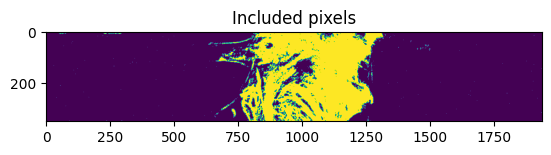

Included pixels:  141258


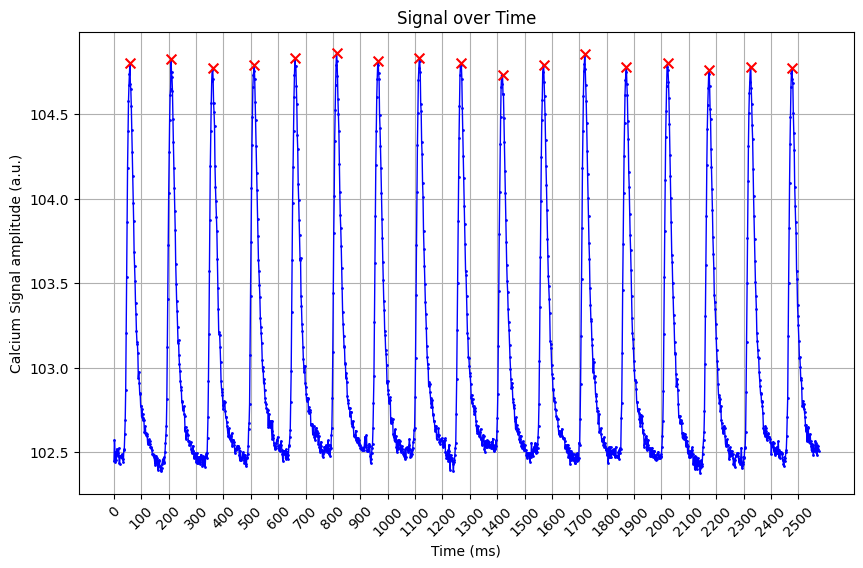

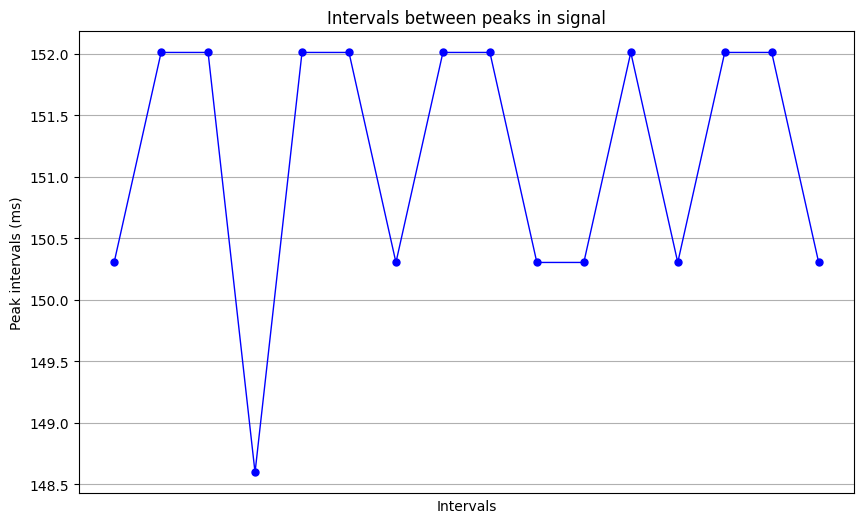

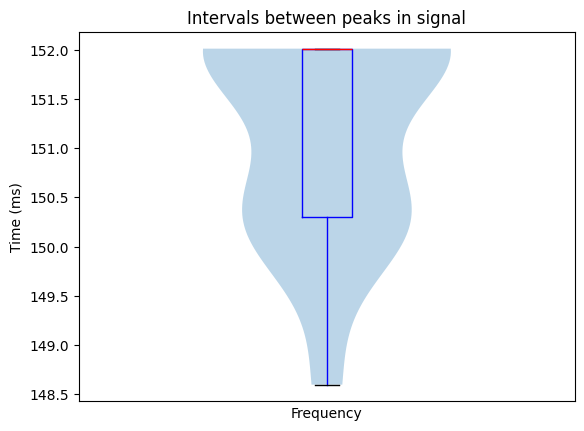

Mean interval (slices):  88.5
Mean interval (ms)(2dp):  151.16
Standard deviation intervals (slices):  0.6123724356957945
Standard deviation intervals (ms)(2dp):  1.05
Frequency (slices):  0.011299435028248588
Frequency (BPM)(2dp):  396.94
Frequency (Hz)(2dp):  6.62


In [ ]:
# interface
root = tk.Tk()
root.title("Apex-Auditor v2")

gui_title_main = tk.Label(root, text="Apex-Auditor", font=("Arial", 22, "bold"))
gui_title_main.pack(pady=5)

gui_title_sub = tk.Label(root, text="Unlocking the secrets of the summits.", font=("Arial", 14, "italic", "bold"))
gui_title_sub.pack(pady=5)

def create_popup():
    popup = tk.Toplevel(root)
    
    popup.title("Apex Auditor v2 Information")

    label = tk.Label(popup, text="These are instructions for using the Apex-Auditor V2 to extract a signal from active pixels within an image.")
    label.pack(pady=2)
    label = tk.Label(popup, text="There is a 3 step process:")
    label.pack(pady=2)
    label = tk.Label(popup, text="1) Select tif files for analysis (in order). If multiple files are selected they will be concatenated to get a long signal. ")
    label.pack(pady=2)
    label = tk.Label(popup, text="2) 'get pixels' will generate a 'mask' highlighting active pixels from the selection (only the first 1000 z slices are used for the mask).")
    label.pack(pady=2)
    label = tk.Label(popup, text="An image of the mask is shown in the Jupyter notebook, and the number of included pixels is listed.")
    label.pack(pady=2)
    label = tk.Label(popup, text="3) 'get signals' will then extract the oscillating calcium signal (and peaks) from the concatenated tiffs, only for pixels in the mask.")
    label.pack(pady=2)
    label = tk.Label(popup, text="The signal, and peaks, will be shown visually in the Jupyter notebook, along with statistics about the intervals.")
    label.pack(pady=2)
    label = tk.Label(popup, text="'get signals' finds the peak using sensible default settings.")
    label.pack(pady=2)
    label = tk.Label(popup, text="If the peaks have not been found correctly then settings can be changed, and 'get signals' pressed again to optimise peak finding.")
    label.pack(pady=2)
    label = tk.Label(popup, text="'prominence' is the minimum relative amplitude of a peak compared to its highest trough; default is 0.5 (50%) of the max signal range.")
    label.pack(pady=2)
    label = tk.Label(popup, text="'prominence' is the most generally useful setting.")
    label.pack(pady=2)
    label = tk.Label(popup, text="'height' is the minimum absolute amplitude of a peak; its default is 0.1 (10%) of the max signal range.")
    label.pack(pady=2)
    label = tk.Label(popup, text="'threshold' is the maximum height of a peak above its immediate neighbours; by default 0.1 of max signal range.")
    label.pack(pady=2)
    label = tk.Label(popup, text="'distance' refers to the minimum distance between peaks; by default it is 5 slices (not ms).")
    label.pack(pady=2)
    label = tk.Label(popup, text="By default calculations use 1.708 ms per slice, but this can be changed.")
    label.pack(pady=2)
    label = tk.Label(popup, text="4) once a signal (and peaks) has been loaded, it can be saved as a csv file. File name and location must be specified.")
    label.pack(pady=2)

    close_button = tk.Button(popup, text="Close", command=popup.destroy)
    close_button.pack(pady=10)

open_popup_button = tk.Button(root, text="More info", font=("Arial", 10), command=create_popup)
open_popup_button.pack(pady=2)

selected_file_paths = [None] * 10
gui_files_frame = {}
gui_files_label = {}
gui_files_button = {}
def gui_update_file_list():

    for index in range(len(selected_file_paths)):
        any_greater_not_none = any(selected_file_paths[index:])
        if index == 0 or (index > 0 and selected_file_paths[index - 1]) is not None or any_greater_not_none:
            if index not in gui_files_frame:
                gui_files_frame[index] = tk.Frame(gui_filelist_frame)
            gui_files_frame[index].pack(pady=1)
            
            for widget in gui_files_frame[index].winfo_children():
                widget.destroy()

            file_name = os.path.basename(selected_file_paths[index]) if selected_file_paths[index] else "No file selected"
            gui_files_label[index] = tk.Label(gui_files_frame[index], text=f"File {index+1}: {file_name}", font=("Arial", 8))
            gui_files_label[index].pack(side="left", padx=(5, 5))

            if selected_file_paths[index]:
                gui_files_button[index] = tk.Button(gui_files_frame[index], text="Clear selection", font=("Arial", 8),
                                                command=lambda idx=index: gui_unselect_file(idx))
                gui_files_button[index].pack(pady=1)
            else:
                gui_files_button[index] = tk.Button(gui_files_frame[index], text="Browse", font=("Arial", 8),
                                                command=lambda idx=index: gui_select_file(idx))
                gui_files_button[index].pack(pady=1)
        else:
            if index in gui_files_frame:
                gui_files_frame[index].pack_forget()

def gui_select_file(index):
    selected_file_path = filedialog.askopenfilename()
    if selected_file_path:
        file_name = os.path.basename(selected_file_path)
        if selected_file_path.lower().endswith(('.tif', '.tiff')):
            selected_file_paths[index] = selected_file_path
            gui_files_label[index].config(text=f"Selected File: {file_name}")
            gui_log_entry(f"{file_name} added to list.\n")
        else:
            gui_log_entry(f"Error. {file_name} is not a tiff.\n")
    gui_update_file_list()

def gui_unselect_file(index):
    file_name = os.path.basename(selected_file_paths[index])
    selected_file_paths[index] = None
    gui_files_label[index].config(text=f"Selected File: {file_name}")
    gui_log_entry(f"{file_name} removed from list.\n")
    gui_update_file_list()

gui_filelist_frame = tk.Frame(root)
gui_filelist_frame.pack(padx=10, pady=5, fill="both", expand=True)
gui_update_file_list()

mask_pixels = None
number_of_pixels = None
def gui_update_pixels():
    if not hasattr(gui_pixels_frame, 'gui_pixels_button'):
        gui_pixels_frame.gui_pixels_button = tk.Button(gui_pixels_frame, font=("Arial", 10))
        gui_pixels_frame.gui_pixels_button.pack(side="left", padx=(10, 10))
        gui_pixels_frame.gui_pixels_button_label = tk.Label(gui_pixels_frame, font=("Arial", 10))
        gui_pixels_frame.gui_pixels_button_label.pack(pady=1)
    if mask_pixels is not None:
        gui_pixels_frame.gui_pixels_button.config(text="Clear Pixel Mask", command=gui_clear_pixels)
        gui_pixels_frame.gui_pixels_button_label.config(text="Pixel Mask loaded")
    elif mask_pixels is None:
        gui_pixels_frame.gui_pixels_button.config(text="Get Pixel Mask", command=gui_get_pixels)
        gui_pixels_frame.gui_pixels_button_label.config(text="")
        
def gui_clear_pixels():
    global mask_pixels
    mask_pixels = None
    gui_update_pixels()

def gui_get_pixels():
    if selected_file_paths[0]:
        gui_log_entry(f"Fetching pixels...\n")
        file_name = os.path.basename(selected_file_paths[0])
        print(file_name)
        get_pixel_mask(selected_file_paths[0])        
    else:
        gui_log_entry(f"Error: No file selected.\n")
    gui_update_pixels()

gui_pixels_frame = tk.Frame(root)
gui_pixels_frame.pack(pady=1)
gui_update_pixels()

gui_settings_frame = tk.Frame(root)
gui_settings_frame.pack(pady=2)

gui_settings_prominence_label = tk.Label(gui_settings_frame, text="Prominence:", font=("Arial", 10))
gui_settings_prominence_label.pack(side="left", padx=(5, 0))
gui_settings_prominence_entry = tk.Entry(gui_settings_frame, font=("Arial", 10), width=10)
gui_settings_prominence_entry.pack(side="left", padx=(0, 5))

gui_settings_height_label = tk.Label(gui_settings_frame, text="Height:", font=("Arial", 10))
gui_settings_height_label.pack(side="left", padx=(5, 0))
gui_settings_height_entry = tk.Entry(gui_settings_frame, font=("Arial", 10), width=10)
gui_settings_height_entry.pack(side="left", padx=(0, 5))

gui_settings_threshold_label = tk.Label(gui_settings_frame, text="Threshold:", font=("Arial", 10))
gui_settings_threshold_label.pack(side="left", padx=(5, 0))
gui_settings_threshold_entry = tk.Entry(gui_settings_frame, font=("Arial", 10), width=10)
gui_settings_threshold_entry.pack(side="left", padx=(0, 5))

gui_settings_distance_label = tk.Label(gui_settings_frame, text="Distance:", font=("Arial", 10))
gui_settings_distance_label.pack(side="left", padx=(5, 0))
gui_settings_distance_entry = tk.Entry(gui_settings_frame, font=("Arial", 10), width=10)
gui_settings_distance_entry.pack(side="left", padx=(0, 5))

ms_per_slice = 1.708
def set_time():
    time_input = gui_time_entry.get()
    global ms_per_slice
    if time_input:
        try:
            ms_per_slice = int(time_input)
            gui_log_entry(f"ms per slice set to: {ms_per_slice}\n")
        except:
            gui_log_entry("Invalid ms per slice entry. ms per slice set to default 1.708.\n")
            ms_per_slice = 1.708
    else:
        gui_log_entry("ms per slice set to default 1.708.\n")
        ms_per_slice = 1.708
    gui_time_label.config(text=f"ms per slice: {ms_per_slice}")

gui_time_frame = tk.Frame(root)
gui_time_frame.pack(pady=2)
gui_time_label = tk.Label(gui_time_frame, text=f'ms per slice: {ms_per_slice}', font=("Arial", 10))
gui_time_label.pack(side="left", padx=(5, 0))
gui_time_button = tk.Button(gui_time_frame, text="Change time", font=("Arial", 10), command=set_time)
gui_time_button.pack(side="left", padx=(5, 0))
gui_time_entry = tk.Entry(gui_time_frame, font=("Arial", 10), width=10)
gui_time_entry.pack(side="left", padx=(5, 0))

global_data = {}
def gui_get_signal():
    global global_data
    signals = []
    if selected_file_paths[0] is not None:
        shape_first = get_shape_first(selected_file_paths[0])
        if mask_pixels is not None:
            if number_of_pixels is not None:
                for file_path in selected_file_paths:
                    if file_path:
                        signal = get_signal(file_path, shape_first)
                        signals.append(signal)
            else:
                gui_log_entry(f"Error: No pixels within Mask.\n")
        else:
            gui_log_entry(f"Error: Mask not defined.\n")
    else:
        gui_log_entry(f"Error: No file to process.\n")

    concatenated_signal = np.concatenate(signals)

    global_data['global_signal'] = crop_signal(concatenated_signal)

    prominence_input = gui_settings_prominence_entry.get()
    height_input = gui_settings_height_entry.get()
    threshold_input = gui_settings_threshold_entry.get()
    distance_input = gui_settings_distance_entry.get()
    if prominence_input:
        try:
            prominence_val = int(prominence_input)
            gui_log_entry(f"Prominence set to: {prominence_val}\n")
        except:
            gui_log_entry("Invalid prominence entry. Prominence set to default 0.5.\n")
            prominence_val = 0.5
    else:
        gui_log_entry("Prominence set to default 0.5.\n")
        prominence_val = 0.5
            
    if height_input:
        try:
            height_val = int(height_input)
            gui_log_entry(f"Height set to: {height_val}\n")
        except:
            gui_log_entry("Invalid height entry. Height set to default 0.1.\n")
            height_val = 0.1
    else:
        gui_log_entry("Height set to default 0.1.\n")
        height_val = 0.1
            
    if threshold_input:
        try:
            threshold_val = int(threshold_input)
            gui_log_entry(f"Threshold set to: {threshold_val}\n")
        except:
            gui_log_entry("Invalid threshold entry. Threshold set to default of 0.1.\n")
            threshold_val = 0.1
    else:
        gui_log_entry("Threshold set to default 0.1.\n")
        threshold_val = 0.1

    if distance_input:
        try:
            distance_val = int(distance_input)
            gui_log_entry(f"Distance set to: {distance_val}\n")
        except:
            gui_log_entry("Invalid distance entry. Distance set to default 5.\n")
            distance_val = 5
    else:
        gui_log_entry("Distance set to default 5.\n")
        distance_val = 5

    gui_log_entry(f"ms per slice set to: {ms_per_slice}\n")

    gui_log_entry("Identifying peaks...\n")
    global_data = get_global_peaks(global_data, prominence_val, height_val, threshold_val, distance_val)
    
    gui_log_entry("Plotting signal (to Jupyter notebook).\n")
    plot_global_signal(global_data, ms_per_slice)
    
    if len(global_data['global_peak_zs']) > 1:
        gui_log_entry("Gathering peak info...\n")
        plot_intervals_global(global_data, ms_per_slice)
        print_signal_info(global_data, ms_per_slice)
    else:
        gui_log_entry("Too few peaks, unable to plot signal info...\n")

gui_signal_frame = tk.Frame(root)
gui_signal_frame.pack(pady=2)
gui_signal_button = tk.Button(gui_signal_frame, text="Get Signal", font=("Arial", 10), command=gui_get_signal)
gui_signal_button.pack(side="left", padx=(10, 0))

csv_save_path = None
csv_file_name = None
def gui_set_csv_path():
    global csv_save_path
    csv_save_path = filedialog.askdirectory()
    if csv_save_path is not None:
        gui_csv_path.config(text=f"Save path: {csv_save_path}")

def gui_save_csv():
    if csv_save_path is not None:
        csv_file_name = gui_csv_entry.get()
        if csv_file_name:
            save_csv(global_data, ms_per_slice, csv_save_path, csv_file_name)
        else:
            gui_log_entry("Error: please specify a file name.\n")
    else:
        gui_log_entry("Error: no file path selected.\n")
        
gui_csv_frame = tk.Frame(root)
gui_csv_frame.pack(pady=2)
gui_csv_button_browse = tk.Button(gui_csv_frame, text="Select save directory", font=("Arial", 10), command=gui_set_csv_path)
gui_csv_button_browse.pack(side="left", padx=(5, 0))
gui_csv_label = tk.Label(gui_csv_frame, text="File name:", font=("Arial", 10))
gui_csv_label.pack(side="left", padx=(5, 0))
gui_csv_entry = tk.Entry(gui_csv_frame, font=("Arial", 10), width=10)
gui_csv_entry.pack(side="left", padx=(5, 0))
gui_csv_button_save = tk.Button(gui_csv_frame, text="Save signal", font=("Arial", 10), command=gui_save_csv)
gui_csv_button_save.pack(side="left", padx=(5, 0))

gui_csv_path = tk.Label(root, text=f"Save path: {csv_save_path}", font=("Arial", 10))
gui_csv_path.pack(pady=2)

def gui_log_entry(text):
    gui_log.config(state=tk.NORMAL)
    gui_log.insert(tk.END, text)
    gui_log.config(state=tk.DISABLED)
    root.update()

gui_log = tk.Text(root, height=8, width=80)
gui_log.pack(pady=10, padx=10)
gui_log.config(state=tk.DISABLED)

root.mainloop()